<a href="https://colab.research.google.com/github/ParthikB/F.R.I.E.N.D.S/blob/master/FRIENDS_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
PROGRESS LADDER:

            Similarity Score between some person and F.R.I.E.N.D.S. Characters
                                          ^
                  Saved Facial Features Value of all the 6 characters
                                          ^
          A Model that will extract the facial feature information from the image
                                        

'''

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
ROOT = '/content/drive/My Drive/Colab Notebooks/friends'
os.chdir(ROOT)

# Importing Libraries

In [22]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import cv2, os
import random

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


# Building the Dataset

In [39]:
PATH = '/dataset/filtered'
os.chdir(ROOT+PATH)

# label = {'ross':0, 'rachel':1}
# dataset = []

# for char in os.listdir():
#   os.chdir(char)
#   for img in tqdm(os.listdir()):
#     img = torch.Tensor(plt.imread(img))
#     dataset.append([img, label[char]])
#     # print(char, img)
    
#   os.chdir(ROOT+PATH)
  


BATCH_SIZE = 16
CLASSES    = 2

TEST_PERCENT = 20

upto = len(dataset)//TEST_PERCENT

# Shuffling the Dataset
random.shuffle(dataset)

train_data = dataset[upto:]
test_data  = dataset[:upto]

# print(len(train_data), len(test_data))

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

print('Training Samples :', len(trainSet.dataset))
print('Testing Samples  :', len(testSet.dataset))

Training Samples : 263
Testing Samples  : 13


### Visualizing a sample

1


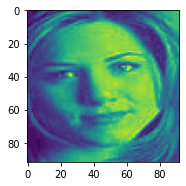

In [38]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch

x, y = trainSet.dataset[i][0], trainSet.dataset[i][1]

DIM, DIM = x.shape
TOTAL_PIXELS = DIM*DIM

t = x.numpy()


plt.subplot(1, 2, 1)
plt.imshow(t) # Reshaping x from (1, DIM, DIM) --> (DIM, DIM, 1)
print(y)

# Defining the Network

In [0]:
  def __init__(self):
    super().__init__()


    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=1, stride=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    # print('total', TOTAL_PIXELS)
    self.fc1   = nn.Linear(self.flatten, 256)
    self.fc2   = nn.Linear(256, 2)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(3, 3), stride=2)
    x = F.relu(self.conv3(x))
    # print(x.shape)

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
      # print('flatten', self.flatten)
    return x

  def get_sim_score(self, img1, img2):
    return F.pairwise_distance(img1.view(-1,  1), img2.view(-1,  1), keepdim=True).float()

  
  # FORWARD PASS
  def forward(self, x):

    features = {}
    for img, type_ in zip(x, ['IR', 'VIS']):
      img = img.to(device)
      img = self.convs(img)
      img = img.view(self.flatten, -1)
      features[type_] = img

    ir_slice = features['IR']
    vis_slice = features['VIS']
    # print(ir_slice.shape)
    
    # CONCATINATION
    # Getting the Euclidian Distance
    edist = self.get_sim_score(ir_slice, vis_slice)

    edist = edist.view(-1, self.flatten) # self.flatten = 2304
    # print('sm', sm.shape)

    sm = F.relu(self.fc1(edist))
    # print(fc1)
    label = self.fc2(sm)
    # print(label.shape)

    return label, sm

In [0]:
def train(net, train_set, loss_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc=f'Iteration > {epoch}/{EPOCHS} : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        
        # Compute Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
 
    loss_log.append(loss)
  
  return loss_log



def test(net, test_set, find_accuracy=True):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  sm_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)

        sm_log.append([sm, real_class])

        total += 1
        if real_class == pred_class:
          correct += 1

  accuracy = (correct/total)*100
  print()
  print(f'Test Accuracy : {round(accuracy, 2)} %')
  return accuracy, sm_log

# Training

Initiating Training..



Initiating Testing..




Test Accuracy : 36.71 %
Total Epochs : 20


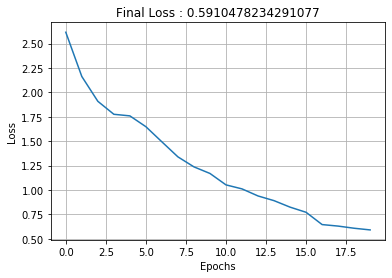

In [0]:
EPOCHS        = 5
LEARNING_RATE = 0.0001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 1

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log = train(net, trainSet, loss_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Final Loss : {loss_log[-1]}')

accuracy, sm_log = test(net, testSet)

print(f'Total Epochs : {total_epochs}')

# Heatmap

In [0]:
def mean(list):
  return sum(list)/len(list)

# CREATING A DICT THAT CONTAINS THE RESPECTIVE SM
classes = {}

for data in (sm_log):
  sm, label = data
  label = label.numpy()
  sm = sm.cpu().numpy()
  
  try:
    classes[str(label)].append(sm)
  except:
    classes[str(label)] = [sm]


# FINDING THE MINIMUM SAMPLES to CLIP
clip = 1000
for i in classes.keys():
  clip = min(clip, len(classes[i]))


# CLIPPING ALL THE CLASSES SAMPLES TO THE MINIMUM
for i in classes.keys():
  classes[i] = classes[i][:clip]

# CREATING A MASTER IN ORDER
master = []
for c in sorted(classes.keys()):
  master.append(np.array(classes[c]))

# CREATING A MAP LIST TO PLOT
edist_log=[]
for class1 in master:
  class1 = torch.Tensor(class1.mean(axis=1))
  for class2 in master:
    class2 = torch.Tensor(class2.mean(axis=1))
    edist = F.pairwise_distance(class1.view(-1,  1), class2.view(-1,  1), keepdim = True).float().numpy()
    edist_log.append(edist.mean())

map = np.array(edist_log).reshape(10, 10)
sns.heatmap(map)

# Extra

In [0]:
from PIL import Image

In [0]:
# !wget https://pmctvline2.files.wordpress.com/2019/06/friends-rachel.jpg?w=620

rach1 = Image.open('/content/friends-rachel.jpg')

In [0]:
# !wget https://vignette.wikia.nocookie.net/friends/images/5/56/Friends-Rachel_Green-Jennifer_Aniston-younger_4.jpg/revision/latest/top-crop/width/300/height/300?cb=20190828233528

rach2 = Image.open('/content/rach2.jpg')

In [0]:
rach3 = Image.open('/content/rach3.jpg')
ross1 = Image.open('/content/ross.jpg')


In [0]:
chimp1 = Image.open('/content/chimp1.jpg')
chimp2 = Image.open('/content/chimp2.jpg')

In [0]:
def get_sm(net, image):
  print('Initiating Testing..')

  with torch.no_grad():
    # for data in tqdm_notebook(test_set):
      # x, y = data
      image_arr = np.array(image)
      x = cv2.resize(image_arr, (DIM, DIM))
      x = torch.Tensor(x)

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

  return sm


sm1 = get_sm(net, rach1)
sm2 = get_sm(net, rach2)
sm3 = get_sm(net, rach3)
sm4 = get_sm(net, ross1)
chimp1 = get_sm(net, chimp1)
chimp2 = get_sm(net, chimp2)

Initiating Testing..
Initiating Testing..
Initiating Testing..
Initiating Testing..
Initiating Testing..
Initiating Testing..


In [0]:
def get_sim_score(sm1, sm2):
  score = F.pairwise_distance(sm1.view(-1,  1), sm2.view(-1,  1), keepdim = True).float().cpu().numpy()
  return score.mean()

scores = [sm1, sm2, sm3, sm4, chimp1, chimp2]

for i in range(len(scores)):
  for j in range(i+1, len(scores)):
    print(f'sm{i+1}-sm{j+1} :', get_sim_score(scores[i], scores[j]))

sm1-sm2 : 12.763027
sm1-sm3 : 4.895035
sm1-sm4 : 7.4979563
sm1-sm5 : 8.080718
sm1-sm6 : 7.7464666
sm2-sm3 : 10.662391
sm2-sm4 : 8.848873
sm2-sm5 : 14.154539
sm2-sm6 : 10.706717
sm3-sm4 : 6.3889136
sm3-sm5 : 8.656348
sm3-sm6 : 7.5454574
sm4-sm5 : 8.469106
sm4-sm6 : 5.724091
sm5-sm6 : 7.65348


In [0]:
sm1.shape

torch.Size([1, 512])

In [0]:
def res(sm):
  return sm.reshape(32, 16).cpu()

t1 = res(sm1)
t2 = res(sm2)


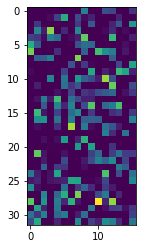

In [0]:
plt.imshow(t1)

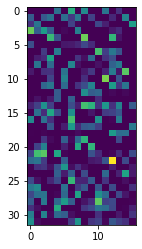

In [0]:
plt.imshow(t2)

In [0]:
torch.mean(t1-t2)

tensor(-7.1417)

# VGG

In [0]:
import torchvision.models as models
import urllib, numpy as np, cv2
from google.colab.patches import cv2_imshow

### Url To Image

In [0]:
def urlToImage(url):
  resp = urllib.request.urlopen(url)
  img = np.asarray(bytearray(resp.read()), dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  img2show = img.copy()

  img = np.rollaxis(img, 2, 0)
  img = np.expand_dims(img, axis=0)
  return img2show, img  
  
ross_list = ['https://a1cf74336522e87f135f-2f21ace9a6cf0052456644b80fa06d4f.ssl.cf2.rackcdn.com/images/characters_opt/p-friends-david-schwimmer.jpg',
              'https://66.media.tumblr.com/135ab23e998d92a23753ce36cbe25081/tumblr_inline_p7p7jif5hx1syfsdr_500.jpg',
              # 'https://i.pinimg.com/originals/36/03/48/36034842250720f106913c53d9f2da9d.jpg',
              'https://upload.wikimedia.org/wikipedia/en/thumb/d/da/Matt_LeBlanc_as_Joey_Tribbiani.jpg/220px-Matt_LeBlanc_as_Joey_Tribbiani.jpg',
             'http://images.fanpop.com/images/image_uploads/Rachel-rachel-green-130496_500_402.jpg']

ross = {}
for idx, url in enumerate(ross_list, 1):
  ross[f'ross_{idx}'] = urlToImage(url)

# cv2_imshow(img2show)
# print(img.shape)

### Model

In [0]:
model = models.resnet50(pretrained=True)
list(model.children())[4][2]

Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [0]:
def get_features(input_img):
  '''
  >> A function that return the features of the 'input_img'.
  type_of_feature --> content/style
  '''
  layers = [4]
  
  outputs= []
  def hook(module, input, output):
      outputs.append(output)

  # Creating a dictionary containing the children of the layers
  features = {}
  for idx, layer_num in enumerate(layers):
    features['feature_' + str(idx)] = list(model.children())[2][layer_num]

  # Hooking the network to get the output of every layer in the features dict.
  for i in range(len(layers)):
    features['feature_' + str(i)].register_forward_hook(hook)
  
  # Passing the image through the network
  final_output_which_is_not_needed = model(input_img)
  
  # Returning the features
  return outputs


def sigmoid(x):
  return 1/(1+ (np.e)**(-x))

def get_sim_score(sm1, sm2):
  score = F.pairwise_distance(sm1.view(-1,  1), sm2.view(-1,  1), keepdim = True).float().detach().cpu().numpy()
  score = score.mean()
  # return 1 - sigmoid(score)
  return score


In [0]:
ross_features = {}
for idx, k in tqdm(enumerate(ross.keys(), 1)):
  print(idx, k)
  ross_features[f'ross_f{idx}'] = get_features(torch.Tensor(ross[k][1]))
  # break


1 ross_1



TypeError: ignored

In [0]:
ross_features

{'ross_f1': [tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReluBackward1>),
  tensor([[11.5817,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
         grad_fn=<ReluBackward1>),
  tensor([[0.7462, 0.0000, 3.0694,  ..., 0.0000, 1.8212, 0.3815]],
         grad_fn=<ReluBackward1>),
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 13.0593]],
         grad_fn=<ReluBackward1>),
  tensor([[9.9060, 0.0000, 0.3788,  ..., 0.0000, 0.0000, 1.8402]],
         grad_fn=<ReluBackward1>)],
 'ross_f2': [tensor([[11.5817,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
         grad_fn=<ReluBackward1>),
  tensor([[0.7462, 0.0000, 3.0694,  ..., 0.0000, 1.8212, 0.3815]],
         grad_fn=<ReluBackward1>),
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, 13.0593]],
         grad_fn=<ReluBackward1>),
  tensor([[9.9060, 0.0000, 0.3788,  ..., 0.0000, 0.0000, 1.8402]],
         grad_fn=<ReluBackward1>)],
 'ross_f3': [tensor([[0.7462, 0.0000, 3.0694,  ..., 0.0000, 1.8212,

In [0]:
for f in ross_features['ross_f1']:
  print()
  for f2 in ross_features['ross_f1']:
    print(get_sim_score(f, f2))



1.0000001e-06
2.2117863
1.8945799
4.1841583
1.7595961

2.2117863
1.0000001e-06
1.8982443
3.6013234
1.9177842

1.8945799
1.898244
1.0000001e-06
3.8089237
1.0710487

4.184159
3.6013234
3.8089237
1.0000001e-06
3.7426047

1.7595961
1.917784
1.0710485
3.7426045
1.0000001e-06
